# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [91]:
import pandas as pd
import numpy as np

### 1b. Load the data
Call the variable `cigData`. 

In [92]:
cigData = 'CowboyCigsData.csv'
df = pd.read_csv(cigData)

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [93]:
#Use .head() to review 1st observations, looks like indices were placed as first column- we'll want to remove these
df.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


In [94]:
#Drop the 1st column of indices
df.drop(columns = 'Unnamed: 0', inplace = True)

In [95]:
#Recheck 1st few observations to verify column drop was successful
df.head()

,Time,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


In [96]:
#Time column contains date values but they are not of datetime, let's change datatype to match
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       144 non-null    object
 1   #CigSales  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [97]:
#Change the Time to datetime type
df['Time'] = pd.to_datetime(df['Time'], format = '%Y-%m', exact = True)

#Extract only year/month from YYYY-MM-DD
df['Time'] = df['Time'].dt.to_period('M')

In [98]:
#Check datatypes again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype    
---  ------     --------------  -----    
 0   Time       144 non-null    period[M]
 1   #CigSales  144 non-null    int64    
dtypes: int64(1), period[M](1)
memory usage: 2.4 KB


In [99]:
#Check first few observations look as expected
df.head()

,Time,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? <br>
**Only 2 columns present**

In [100]:
df.columns

Index(['Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns. <br>
**2 columns - 'Time' is of object type, we'll want to convert to DateTime to facilitate time series analysis & '#CigSales' is of int64 type, which makes sense for counting # of cigarette sales.**

In [101]:
#Checking datatypes of columns, datetime conversion was completed above
df.dtypes

Time         period[M]
#CigSales        int64
dtype: object

Check whether there are any null values. <br>
**No null values present in either column.**

In [102]:
#Checking presence of null values
df.isnull().sum()

Time         0
#CigSales    0
dtype: int64

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.<br>
**See above, this step was already completed as I noticed 1st column of dataframe was redundant and only contained values of indices.**

In [103]:
#Already completed this step, see above

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [104]:
#Rename 'Time' column to 'Month'
df = df.rename(columns = {'Time': 'Month'})

Call a head() to check this has worked. 

In [105]:
#Verify rename of 'Time' column was successful
df.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [106]:
#Check datatypes of columns
df.dtypes

Month        period[M]
#CigSales        int64
dtype: object

In [107]:
#Month is already of datetime datatype, no conversion needed

In [108]:
#Set index of df to 'Month' column values
df = df.set_index(df['Month']).to_timestamp(freq = 'M').drop(columns = ['Month'])

In [109]:
#Checking index is set to datetime with freq of month
df.index

DatetimeIndex(['1949-01-31', '1949-02-28', '1949-03-31', '1949-04-30',
               '1949-05-31', '1949-06-30', '1949-07-31', '1949-08-31',
               '1949-09-30', '1949-10-31',
               ...
               '1960-03-31', '1960-04-30', '1960-05-31', '1960-06-30',
               '1960-07-31', '1960-08-31', '1960-09-30', '1960-10-31',
               '1960-11-30', '1960-12-31'],
              dtype='datetime64[ns]', name='Month', length=144, freq='M')

In [110]:
#Check that resetting of index was successful
df.head()

,#CigSales
Month,
1949-01-31,1000112
1949-02-28,1000118
1949-03-31,1000132
1949-04-30,1000129
1949-05-31,1000121


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [111]:
#Define predictor variable, '#CigSales' column values
y = df['#CigSales']

Check the type of our new variable. 

In [112]:
#Check type of variable y
type(y)

pandas.core.series.Series

In [113]:
#Inspect y values
y

Month
1949-01-31    1000112
1949-02-28    1000118
1949-03-31    1000132
1949-04-30    1000129
1949-05-31    1000121
               ...   
1960-08-31    1000606
1960-09-30    1000508
1960-10-31    1000461
1960-11-30    1000390
1960-12-31    1000432
Freq: M, Name: #CigSales, Length: 144, dtype: int64

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [114]:
#Summary statistics for y
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

In [115]:
#Import matplotlib 
import matplotlib.pyplot as plt

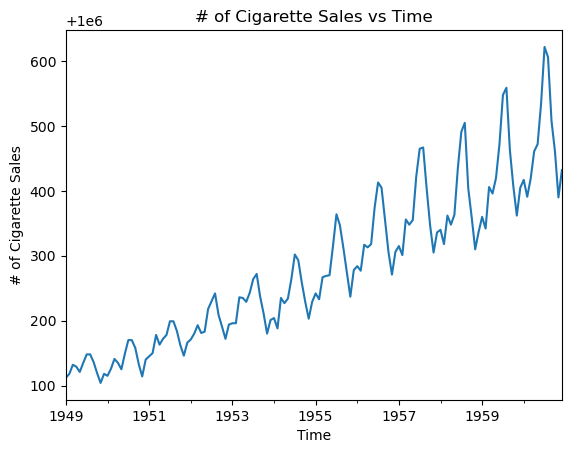

In [116]:
#Create plot of # of Cigarette sales vs Time
y.plot()
plt.xlabel('Time')
plt.ylabel('# of Cigarette Sales')
plt.title('# of Cigarette Sales vs Time')
plt.show()

**General Observations about Time-Series Cigarette Sales Plot** <br>
-# of cigarette sales fluctuates with a regularity <br>
-amount of fluctuation in cigarette sales increases over time <br>
-# of cigarette sales generally increases over time <br>

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

**Season fluctuations could be coming from New Year's Resolutions - many people commit to giving up smoking at the start of the New Year so there is a steep drop in # of cigarette sales in January of each year. Subsequently, there is slow rise in # of cigarette sales as the months of the year pass and people slowly abandon their New Year's Resolutions.**

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

**Given the cigarette sales data over time, a multiplicative model would be more conducive. When using an additive model, the magnitude of seasonality does not change in relation to time. In contrast, with a multiplicative model, the magnitude of the seasonal pattern in the data depends on the magnitude of the data. Since the cyclical pattern in the cigarette sales data seems to increase over time (i.e. is dependent upon the magnitude of the data), a multiplicative model is the appropriate choice.**

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

In [117]:
#Import necessary pacakages
import statsmodels.api as sm

#Use decompose() function on cigarette sales data, specifying a multiplicative model
result = sm.tsa.seasonal_decompose(df)

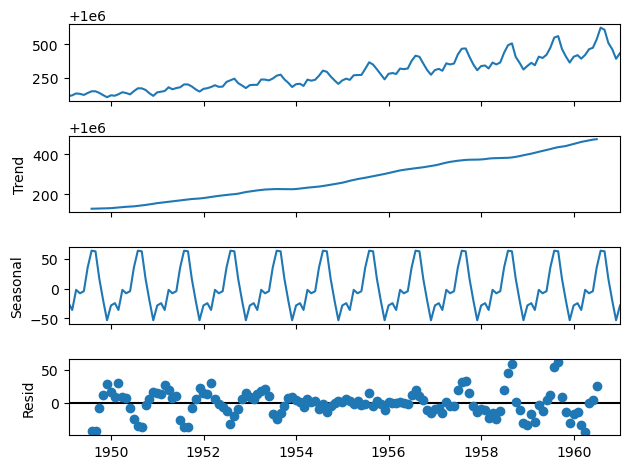

In [118]:
#Plotting result
#1st plot = observed data, 2nd plot = Trend, 3rd = Seasonal, 4th = Residual
result.plot()
plt.show()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [119]:
#Import necessary packages
from statsmodels.tsa.stattools import kpss

#Define function kpss_test() 
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [120]:
#Run kpss_test() function on cigarette sales time series data
kpss_test(y)

Results of KPSS Test:
Test Statistic           1.651312
p-value                  0.010000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

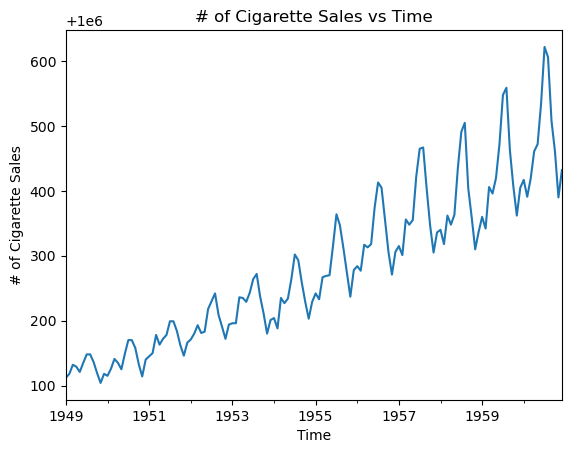

In [121]:
#Recreate plot of # of Cigarette sales vs Time
y.plot()
plt.xlabel('Time')
plt.ylabel('# of Cigarette Sales')
plt.title('# of Cigarette Sales vs Time')
plt.show()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One often  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [122]:
#Use np.log() function to take natural log transform of cigarette sales data
y_log_trsfm = np.log(y)

In [123]:
#Inspect natural log transform of cigarette sales data
y_log_trsfm

Month
1949-01-31    13.815623
1949-02-28    13.815629
1949-03-31    13.815643
1949-04-30    13.815640
1949-05-31    13.815632
                ...    
1960-08-31    13.816116
1960-09-30    13.816018
1960-10-31    13.815971
1960-11-30    13.815900
1960-12-31    13.815942
Freq: M, Name: #CigSales, Length: 144, dtype: float64

In [124]:
np.max(y_log_trsfm)

13.816132364602451

In [125]:
np.min(y_log_trsfm)

13.81561455255665


When you plot this, you can see how the variance in our data now remains contant over time.

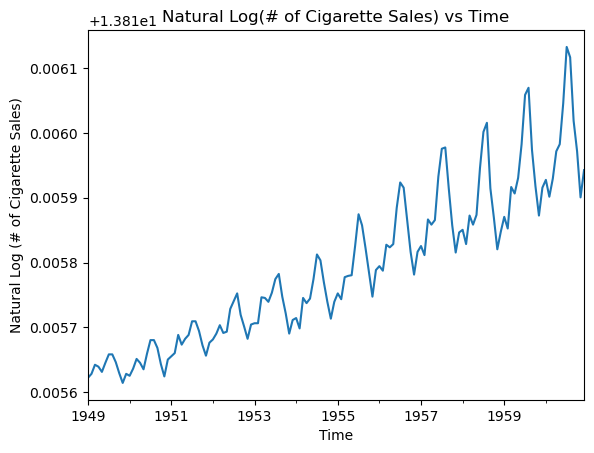

In [126]:
y_log_trsfm.plot()
plt.xlabel('Time')
plt.ylabel('Natural Log (# of Cigarette Sales)')
plt.title('Natural Log(# of Cigarette Sales) vs Time')
plt.show()

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [127]:
#Use diff() function to difference natural log transform data
y_log_diff = y_log_trsfm.diff().dropna()

In [128]:
#Check how many values there are, since it is taking differences in natural log transform data there is 1 less value present
y_log_diff.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 143 entries, 1949-02-28 to 1960-12-31
Freq: M
Series name: #CigSales
Non-Null Count  Dtype  
--------------  -----  
143 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


In [129]:
#Use .head() command to see if difference natural log transform data looks as expected
y_log_diff.head()

Month
1949-02-28    0.000006
1949-03-31    0.000014
1949-04-30   -0.000003
1949-05-31   -0.000008
1949-06-30    0.000014
Freq: M, Name: #CigSales, dtype: float64

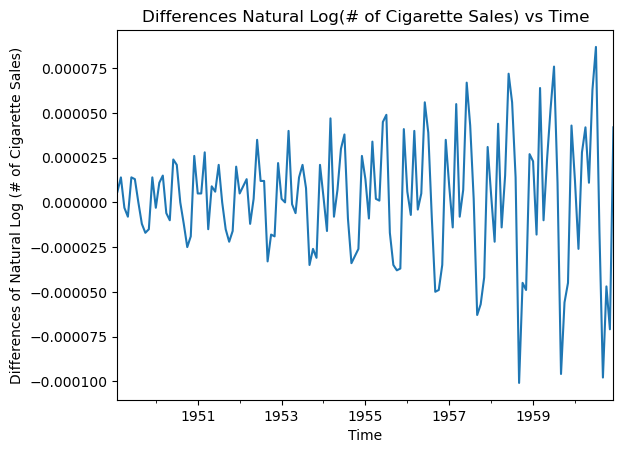

In [130]:
#Plot differences of natural log transform data vs time
y_log_diff.plot()
plt.xlabel('Time')
plt.ylabel('Differences of Natural Log (# of Cigarette Sales)')
plt.title('Differences Natural Log(# of Cigarette Sales) vs Time')
plt.show()

In [131]:
#Run kpss_test() on natural log transform differences data
kpss_test(y_log_diff)

Results of KPSS Test:
Test Statistic           0.023898
p-value                  0.100000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [132]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [133]:
import warnings
warnings.filterwarnings("ignore")

In [134]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions. Declare a variable with that name
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future = model_fit.predict()[0]
        # Append() here
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [135]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p, d, q)
                try:
                # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [136]:
# Now, we choose a couple of values to try for each parameter.
p_vals = [x for x in range(0,3)]
d_vals = [x for x in range(0,3)]
q_vals = [x for x in range(0,3)]

In [137]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
#Using log differences
evaluate_models(y_log_diff, p_vals, d_vals, q_vals)

ARIMA(0, 0, 0) MSE=0.000
ARIMA(0, 0, 1) MSE=0.000
ARIMA(0, 0, 2) MSE=0.000
ARIMA(0, 1, 0) MSE=0.000
ARIMA(0, 1, 1) MSE=0.000
ARIMA(0, 1, 2) MSE=0.000
ARIMA(0, 2, 0) MSE=0.000
ARIMA(0, 2, 1) MSE=0.000
ARIMA(0, 2, 2) MSE=0.000
ARIMA(1, 0, 0) MSE=0.000
ARIMA(1, 0, 1) MSE=0.000
ARIMA(1, 0, 2) MSE=0.000
ARIMA(1, 1, 0) MSE=0.000
ARIMA(1, 1, 1) MSE=0.000
ARIMA(1, 1, 2) MSE=0.000
ARIMA(1, 2, 0) MSE=0.000
ARIMA(1, 2, 1) MSE=0.000
ARIMA(1, 2, 2) MSE=0.000
ARIMA(2, 0, 0) MSE=0.000
ARIMA(2, 0, 1) MSE=0.000
ARIMA(2, 0, 2) MSE=0.000
ARIMA(2, 1, 0) MSE=0.000
ARIMA(2, 1, 1) MSE=0.000
ARIMA(2, 1, 2) MSE=0.000
ARIMA(2, 2, 0) MSE=0.000
ARIMA(2, 2, 1) MSE=0.000
ARIMA(2, 2, 2) MSE=0.000
Best ARIMA(0, 1, 0) MSE=0.000


So the best p,d, q, parameters for our ARIMA model are 0, 1, 0 respectively. Now we know this, we can build the model.

In [138]:
#Run ARIMA model with order 0,1,0 that obtained lowest MSE
p=0
d=1
q=0
model = ARIMA(y_log_diff, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

We can take a look at a summary of the model this library has built around our data.

In [139]:
#Review summary of fitted model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              #CigSales   No. Observations:                  143
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1237.499
Date:                Sun, 12 Nov 2023   AIC                          -2472.999
Time:                        20:00:10   BIC                          -2470.043
Sample:                    02-28-1949   HQIC                         -2471.798
                         - 12-31-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.565e-09   2.96e-10      5.282      0.000    9.84e-10    2.15e-09
Ljung-Box (L1) (Q):                   5.29   Jarque-Bera (JB):                 0.89
Prob(Q):                              0.02   Pr

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

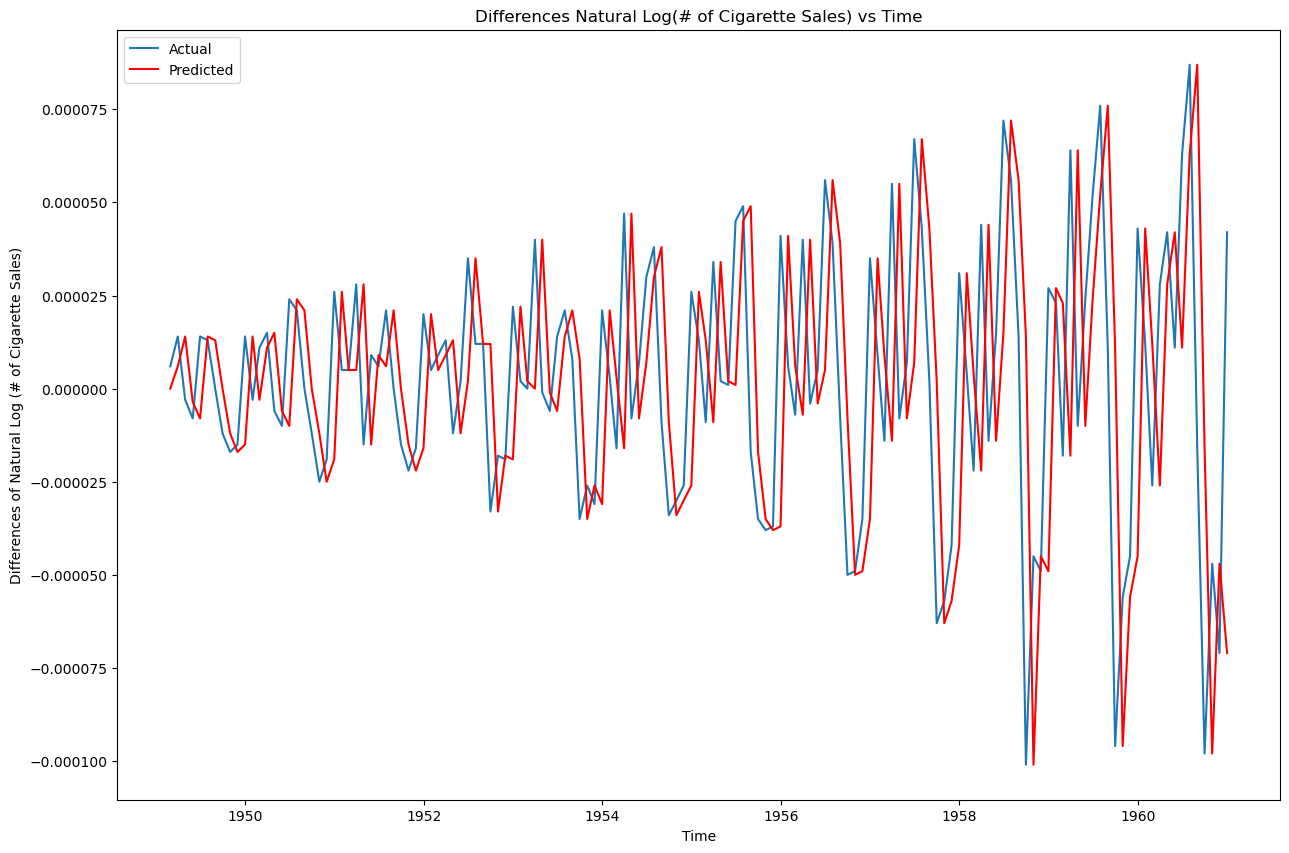

In [140]:
# Call figure() and plot() on the plt
plt.figure(figsize=(15,10))
plt.plot(y_log_diff)
plt.xlabel('Time')
plt.ylabel('Differences of Natural Log (# of Cigarette Sales)')
plt.title('Differences Natural Log(# of Cigarette Sales) vs Time')
plt.plot(model_fit.predict(), color = 'red')
plt.legend(['Actual', 'Predicted'])

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

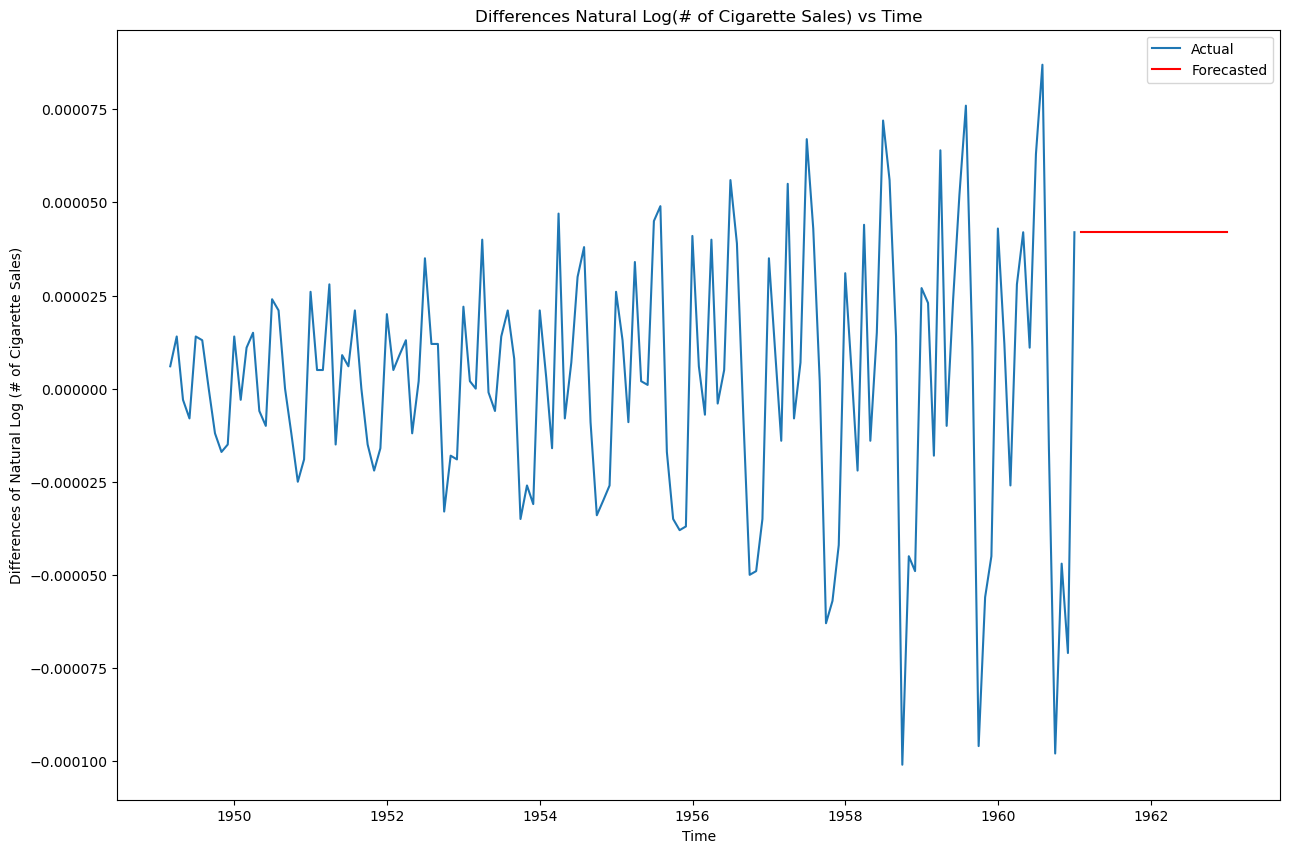

In [90]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 12
date_range = pd.date_range(y_log_diff.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_months = pd.DataFrame(date_range, columns = ['Month'])
#Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Month'] = pd.to_datetime(future_months['Month'])
forecast_df = pd.DataFrame(forecast).reset_index()
forecast_df.columns = ['Month', 'Value']

# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,10))
#Original y data using differences of natural logs
plt.plot(y_log_diff)

#Prediction data
plt.plot(forecast_df['Month'], forecast_df['Value'], color = 'r')
plt.xlabel('Time')
plt.ylabel('Differences of Natural Log (# of Cigarette Sales)')
plt.title('Differences Natural Log(# of Cigarette Sales) vs Time')
plt.legend(['Actual', 'Forecasted'])
plt.show()

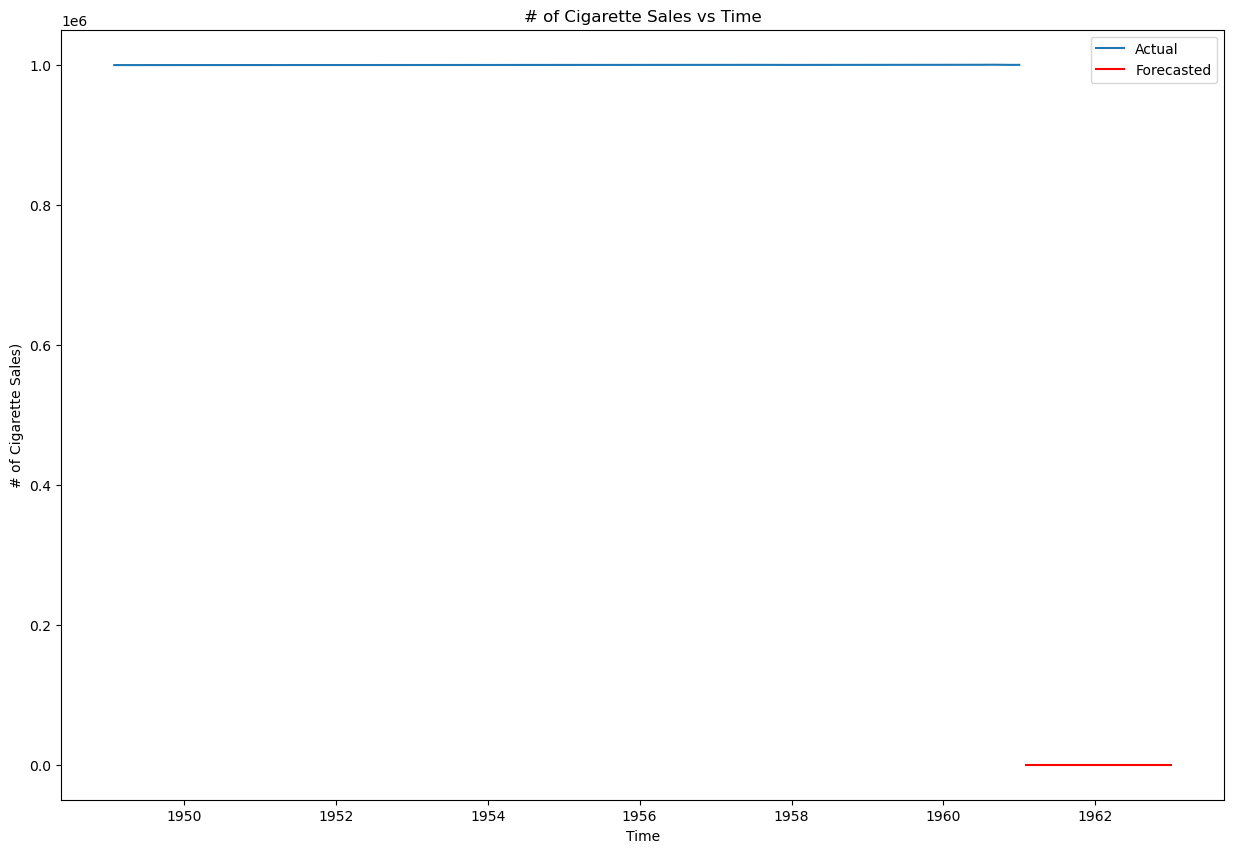

In [148]:
# Now plot the original variable y 
# Use the same functions as before
plt.figure(figsize=(15,10))
plt.plot(y)


#Prediction data
plt.plot(forecast_df['Month'], np.exp(forecast_df.Value), color = 'r')
plt.xlabel('Time')
plt.ylabel('# of Cigarette Sales)')
plt.title('# of Cigarette Sales vs Time')
plt.legend(['Actual', 'Forecasted'])


#Display the plot
plt.plot()
plt.show()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 